In [172]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.cloud import bigquery as bq
from tqdm import tqdm

In [173]:
# TODO: das iid_bootstrapping in vectorisierd machen

# FIXME:

# NOTE:

#Learnings:
#bei meinem Ansatz sind jeweils eine der bound unnötig, weil nie binding
# wenn ich die Formel aus der function rausnehme kommen andere Ergebnisse raus???
# wenn die window size 1 ist, ist das upper bound häufig gleich dem startinedex

#was ich mir nicht erklären kann:
# wie kann bei den Upper bounds ne Null dabei sein?
# der upper bound beim 2. passt nicht zum zero indexing?

# Import Data

In [174]:
class InputData:
    project_id = "brain-flash-dev"
    dataset_id = "dagster_common"
    data_path = "data"

    def __init__(self, file_name: str = "twins_100"):
        """Loads data from a CSV file and initializes unique communication keys."""
        self.data = pd.read_csv(f"{self.data_path}/{file_name}.csv")
        self.TEST_ITEM_COMMUNICATIONKEYS = self.data["TEST_ITEM_COMMUNICATIONKEY"].unique()
        self.TWIN_ITEM_COMMUNICATIONKEYS = self.data["TWIN_ITEM_COMMUNICATIONKEY"].unique()
    
    @classmethod
    def download_from_bq(cls, table_id: str = "CN_data_to_fetch", filename: str = "twins_100"):
        """Downloads data from BigQuery and saves it as a CSV file."""
        client = bq.Client(project=cls.project_id)
        table_ref = f"{cls.project_id}.{cls.dataset_id}.{table_id}"
        
        query = f"SELECT * FROM `{table_ref}`"
        df = client.query(query).to_dataframe()
        df.to_csv(f"{cls.data_path}/{filename}.csv", index=False)

    def get_test_item(self, key: int) -> pd.DataFrame:
        """Retrieves test item data."""
        df = self.data.loc[
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] == self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
            ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
        ].reset_index(drop=True)
        
        nan_count = df.isna().sum().sum()
        if nan_count > 0:
            print(f"There are {nan_count} NaN values in the data which are replaced with 0s.")
            df.fillna(0, inplace=True)
        
        return df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")

    def get_twin_item(self, key: int, num_twins: int) -> pd.DataFrame:
        """Retrieves twin item data."""
        df = self.data.loc[
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] != self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
            ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
        ].reset_index(drop=True)
        
        df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")
        df = df.iloc[:, :num_twins]  # Reduce to the desired number of twin items
        
        nan_count = df.isna().sum().sum()
        if nan_count > 0:
            print(f"There are {nan_count} NaN values in the data which are replaced with 0s.")
            df.fillna(0, inplace=True)
        return df

### Bootstrap

In [175]:
# ist der upper bound in dem window up jemals binding?

#eine Idee für die Intervalle
def get_J_1m(m, b, w, N):
    lb = 0
    middle = m * b - w / 2
    ub = N - b - w / 2 #darf eingentlich nie erreicht werden, weil das m von 0 ... M-1 geht
    # Ensure the value is within the bounds
    return max(lb, min(middle, ub))
def get_J_2m(m, b, w, N):
    lb = 0 #darf eigentlich nie erreicht werden, da wir immer nen halbes window addieren
    middle = m * b + w / 2
    ub = N - b
    # Ensure the value is within the bounds
    return max(lb, min(middle, ub))

#deckt auch den Fall b= 4, w = 2 ab

In [176]:
357/4

89.25

In [177]:
89 * 4 - 0.5*2

355.0

In [178]:
#Block Size: 4, Window Size: 2, M: 90, N: 357
b = 4
w = 2
N = 354
M = int(np.ceil(N / b))
print(np.maximum(1, np.arange(M) * b - 0.5*w))
print(np.minimum(np.arange(M) * b + 0.5*w, N - b + 1))

#sind blöcke größer als das halbe Window gibts nen Fehler in der Formulierung

[  1.   3.   7.  11.  15.  19.  23.  27.  31.  35.  39.  43.  47.  51.
  55.  59.  63.  67.  71.  75.  79.  83.  87.  91.  95.  99. 103. 107.
 111. 115. 119. 123. 127. 131. 135. 139. 143. 147. 151. 155. 159. 163.
 167. 171. 175. 179. 183. 187. 191. 195. 199. 203. 207. 211. 215. 219.
 223. 227. 231. 235. 239. 243. 247. 251. 255. 259. 263. 267. 271. 275.
 279. 283. 287. 291. 295. 299. 303. 307. 311. 315. 319. 323. 327. 331.
 335. 339. 343. 347. 351.]
[  1.   5.   9.  13.  17.  21.  25.  29.  33.  37.  41.  45.  49.  53.
  57.  61.  65.  69.  73.  77.  81.  85.  89.  93.  97. 101. 105. 109.
 113. 117. 121. 125. 129. 133. 137. 141. 145. 149. 153. 157. 161. 165.
 169. 173. 177. 181. 185. 189. 193. 197. 201. 205. 209. 213. 217. 221.
 225. 229. 233. 237. 241. 245. 249. 253. 257. 261. 265. 269. 273. 277.
 281. 285. 289. 293. 297. 301. 305. 309. 313. 317. 321. 325. 329. 333.
 337. 341. 345. 349. 351.]


[  0.   3.   7.  11.  15.  19.  23.  27.  31.  35.  39.  43.  47.  51.
  55.  59.  63.  67.  71.  75.  79.  83.  87.  91.  95.  99. 103. 107.
 111. 115. 119. 123. 127. 131. 135. 139. 143. 147. 151. 155. 159. 163.
 167. 171. 175. 179. 183. 187. 191. 195. 199. 203. 207. 211. 215. 219.
 223. 227. 231. 235. 239. 243. 247. 251. 255. 259. 263. 267. 271. 275.
 279. 283. 287. 291. 295. 299. 303. 307. 311. 315. 319. 323. 327. 331.
 335. 339. 343. 347. 349.]
[  1.   5.   9.  13.  17.  21.  25.  29.  33.  37.  41.  45.  49.  53.
  57.  61.  65.  69.  73.  77.  81.  85.  89.  93.  97. 101. 105. 109.
 113. 117. 121. 125. 129. 133. 137. 141. 145. 149. 153. 157. 161. 165.
 169. 173. 177. 181. 185. 189. 193. 197. 201. 205. 209. 213. 217. 221.
 225. 229. 233. 237. 241. 245. 249. 253. 257. 261. 265. 269. 273. 277.
 281. 285. 289. 293. 297. 301. 305. 309. 313. 317. 321. 325. 329. 333.
 337. 341. 345. 349. 350.]


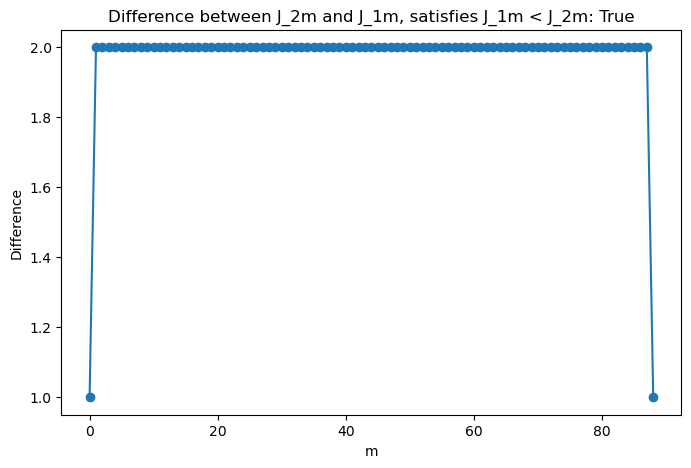

In [179]:
# Compute J_1m and J_2m
J_1m_values = np.array([get_J_1m(m, b, w, N) for m in range(M)])
print(J_1m_values)
J_2m_values = np.array([get_J_2m(m, b, w, N) for m in range(M)])
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

In [180]:
class Sampling:
    num_samples = 50 # maintained on class level to ensure comparability between experiments

    @classmethod
    def iid_bootstrap(cls, data: pd.DataFrame) -> pd.Series:
        """
        müsste ich eigentlich auch durch den local Bootstrap mit B = 1 und b = 1 ersetzen können
        Dann ist nur die indizierung scuffed, weil wir decimal numbers as startpuntke der intervalle haben
        """
        
        N, col = data.shape
        # Precompute column choices for each bootstrap sample
        row_choices = np.random.randint(N, size=(cls.num_samples, N))  # Shape: (num_samples, N)
        col_choices = np.random.randint(col, size=(cls.num_samples, N))  # Shape: (num_samples, N)

        # Extract sampled observations from data using NumPy advanced indexing
        sampled_observations = data.values[row_choices, col_choices]  # Shape: (num_samples, N)

        return pd.Series(np.sum(sampled_observations, axis=1), name="Bootstrap_Sums")

    @classmethod
    def lb_bootstrap(cls, data: pd.DataFrame, window_size: int, b: int) -> pd.Series:
        """
        Performs the Local Block Bootstrap (LBB) method from Paparoditis and Politis (2002) 
        in a vectorized manner with NumPy, adapted to work on multiple sample series.
        
        Parameters:
        - data: pd.DataFrame -> Input time series data
        - B: float -> Locality parameter to determine window size
        - b: int -> Block size for bootstrapping
        
        Returns:
        - pd.Series -> Summed bootstrap samples
        """
        
        N, col = data.shape

        # Number of blocks
        M = int(np.ceil(N / b))

        # Precompute column choices for each bootstrap sample
        col_choices = np.random.randint(col, size=(cls.num_samples, M))  # Shape: (num_samples, M)

        # Compute Neighborhood window starting and ending indices for each block m
        # Note: The -1 is necessary to convert from 1-based to 0-based indexing
        # J_1m = np.maximum(1, np.arange(M) * b - 0.5*window_size)-1  # Shape: (M,)
        # J_2m = np.minimum(np.arange(M) * b + 0.5*window_size, N - b + 1)-1  # Shape: (M,)

        #Test
        J_1m = np.array([get_J_1m(m, b, window_size, N) for m in range(M)])
        J_2m = np.array([get_J_2m(m, b, window_size, N) for m in range(M)])

        
        print(f"Block Size: {b}, Window Size: {window_size}, M: {M}, N: {N}")
        print(J_1m)
        print(J_2m)

        # Generate block starting indices for each block m
        I_m = np.random.randint(J_1m, J_2m+1, size=(cls.num_samples, M))  # Shape: (num_samples, M), +1 to account for open interval

        # Generate row index ranges for each block (vectorized)
        row_ranges = I_m[:, :, None] + np.arange(b)  # Shape: (num_samples, M, b)

        # print(row_ranges)

        # Extract sampled blocks from data using NumPy advanced indexing
        sampled_blocks = data.values[row_ranges, col_choices[:, :, None]]  # Shape: (num_samples, M, b)

        # Flatten each sample into a 1D time series and truncate to length N
        bootstrap_samples = sampled_blocks.reshape(cls.num_samples, -1)[:, :N]  # Shape: (num_samples, N)
        #Christian: soll lieber Zeitreihe vorher auf Vielfaches von b kürzen, als unvollständige Blöcke zu verwenden

        return pd.Series(np.sum(bootstrap_samples, axis=1), name="Bootstrap_Sums")

In [181]:
# kein Zero indexing, inclusive grenzen
N = 357
print(np.maximum(0,np.arange(90) * 4 - 0.5*2))
print(np.minimum(np.arange(90) * 4 + 0.5*2, N-4+1))

[  0.   3.   7.  11.  15.  19.  23.  27.  31.  35.  39.  43.  47.  51.
  55.  59.  63.  67.  71.  75.  79.  83.  87.  91.  95.  99. 103. 107.
 111. 115. 119. 123. 127. 131. 135. 139. 143. 147. 151. 155. 159. 163.
 167. 171. 175. 179. 183. 187. 191. 195. 199. 203. 207. 211. 215. 219.
 223. 227. 231. 235. 239. 243. 247. 251. 255. 259. 263. 267. 271. 275.
 279. 283. 287. 291. 295. 299. 303. 307. 311. 315. 319. 323. 327. 331.
 335. 339. 343. 347. 351. 355.]
[  1.   5.   9.  13.  17.  21.  25.  29.  33.  37.  41.  45.  49.  53.
  57.  61.  65.  69.  73.  77.  81.  85.  89.  93.  97. 101. 105. 109.
 113. 117. 121. 125. 129. 133. 137. 141. 145. 149. 153. 157. 161. 165.
 169. 173. 177. 181. 185. 189. 193. 197. 201. 205. 209. 213. 217. 221.
 225. 229. 233. 237. 241. 245. 249. 253. 257. 261. 265. 269. 273. 277.
 281. 285. 289. 293. 297. 301. 305. 309. 313. 317. 321. 325. 329. 333.
 337. 341. 345. 349. 353. 354.]


### Metrics

$$
W_p(\mu_1, \mu_2) = \left( \int_0^1 \left| F_1^{-1}(q) - F_2^{-1}(q) \right|^p \, dq \right)^{\frac{1}{p}}
$$


In [182]:
class Metrics:

    @staticmethod
    def mse(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Squared Error (MSE) as decomposed into bias^2 and variance.
        
        Parameters:
        - test_data: The ground truth value for comparison (assumed seasonal demand sum).
        - bootstrap_samples: A Pandas Series of bootstrap sample estimates.
        
        Returns:
        - MSE value as a float.
        """
        bias = (np.mean(bootstrap_samples) - np.sum(test_data, axis=0)) ** 2
        
        variance = np.var(bootstrap_samples, ddof=1)  # Using sample variance (ddof=1 for unbiased estimator)
        
        mse = bias + variance
        return mse
    
    @staticmethod
    def mape(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Percentage Error (MAPE) as a percentage value.
        """
        return np.mean(np.abs(bootstrap_samples - np.sum(test_data)) / np.sum(test_data)) * 100

    @staticmethod
    def mae(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Error (MAE).
        """
        return np.mean(np.abs(bootstrap_samples - np.sum(test_data)))

    @staticmethod
    def discrete_wasserstein(dist1: pd.Series, dist2:pd.Series, p: int= 2):
        """
        Compute the p-Wasserstein distance between two discrete one dimensional distributions.
        
        Parameters:
        - dist1: np.array, first distribution samples
        - dist2: np.array, second distribution samples
        - p: int, order of Wasserstein distance
        
        Returns:
        - Wasserstein-p distance (float)
        """
        dist1_sorted = np.sort(dist1)
        dist2_sorted = np.sort(dist2)

        return np.power(np.sum(np.abs(dist1_sorted - dist2_sorted) ** p) / len(dist1), 1 / p)

### Parameter Evaluation

In [183]:
class Evaluation:

    def __init__(self, input_data):
        self.input_data = input_data

    def single_evaluation(self, key: int):
        """
        helps to avoid waiting time in debugging
        """
        pass

    def full_evaluation(self, window_size, block_size, num_twins):
        """
        Perform a full evaluation over all test items.
        I could save time by fetching the data in one batch -> include twin item selection in a later step
        """
        results_list = [
            {
                "TEST_ITEM_COMMUNICATIONKEY": test_item,
                "window_size": window_size,
                "block_size": block_size,
                "num_twins": num_twins,
                "MSE": np.mean(Metrics.mse(
                    self.input_data.get_test_item(test_item),
                    Sampling.lb_bootstrap(self.input_data.get_twin_item(test_item, num_twins), window_size, block_size)
                ))
            }
            for test_item in self.input_data.TEST_ITEM_COMMUNICATIONKEYS
        ]

        return pd.DataFrame(results_list)

    def evaluate_parameter_grid(self, max_twin_num: int = 10, max_block_size: int = 30, max_window_size: int = 60):
        #select reasonable max parameter values

        block_sizes = np.arange(1, max_block_size + 1)
        window_size = np.arange(2, max_window_size +2 , 2)
        param_grid = [(w, b, max_twin_num) for w in window_size for b in block_sizes]

        results_list = []

        for params in tqdm(param_grid, desc="Grid Search Evaluation"):
        
            # try:
            #     run_results = run_evalutation(input_data, w, num_twins, b)
            #     print(f"Succes for window_size = {w}, b = {b}, Twins = {num_twins}")
            # except Exception as e:
            #     print(f"Failed for window_size = {w}, b = {b}, Twins = {num_twins}")
            
            results_list.append(self.full_evaluation(*params))
    

        return pd.concat(results_list, ignore_index=True)

In [184]:
evaluator = Evaluation(InputData())

#Beispiel für Funktionalität
#evaluator.full_evalutation(10, 4, 5)

In [185]:
#evaluator.evaluate_parameter_grid()
#Block Size: 4, Window Size: 2, M: 90, N: 357

### Test Area

In [186]:
bootstrap_results = Sampling.lb_bootstrap(test, B=0.1, b=7)
bootstrap_results.plot(kind="hist", bins=50, title="Local Block Bootstrap", edgecolor="black")
plt.show()

NameError: name 'test' is not defined

count    50000.000000
mean       536.748180
std         49.403277
min        343.000000
25%        503.000000
50%        536.000000
75%        569.000000
max        755.000000
Name: Bootstrap_Sums, dtype: float64

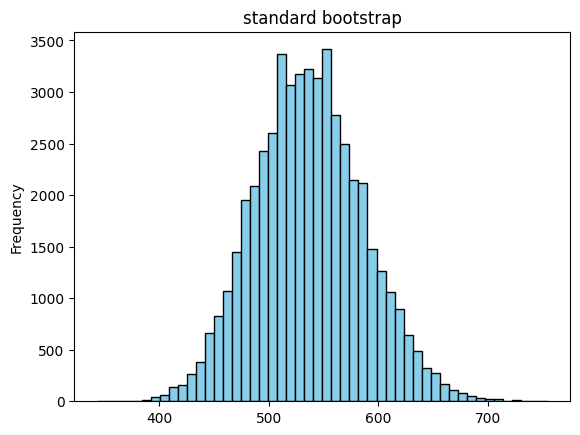

: 

: 

: 

In [ ]:
results_simple = Sampling.iid_bootstrap(twin)
display(results_simple.describe())
results_simple.plot(kind="hist", title="standard bootstrap", bins=50, color="skyblue", edgecolor="black");

count    50000.000000
mean       540.354680
std        101.673639
min        185.000000
25%        469.000000
50%        536.000000
75%        606.000000
max       1013.000000
Name: Bootstrap_Sums, dtype: float64


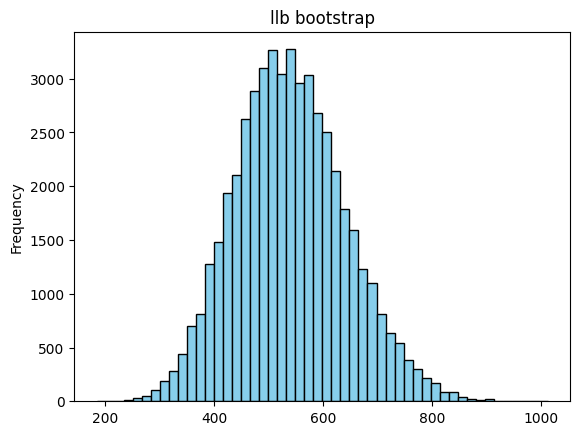

: 

: 

: 

In [ ]:
results_lbb = Sampling.lb_bootstrap(twin, B=0.1, b=7)
print(results_lbb.describe())
results_lbb.plot(kind="hist", bins=50, title="llb bootstrap",color="skyblue", edgecolor="black");

# Normality test
- tune number of iteration until distribution is normal

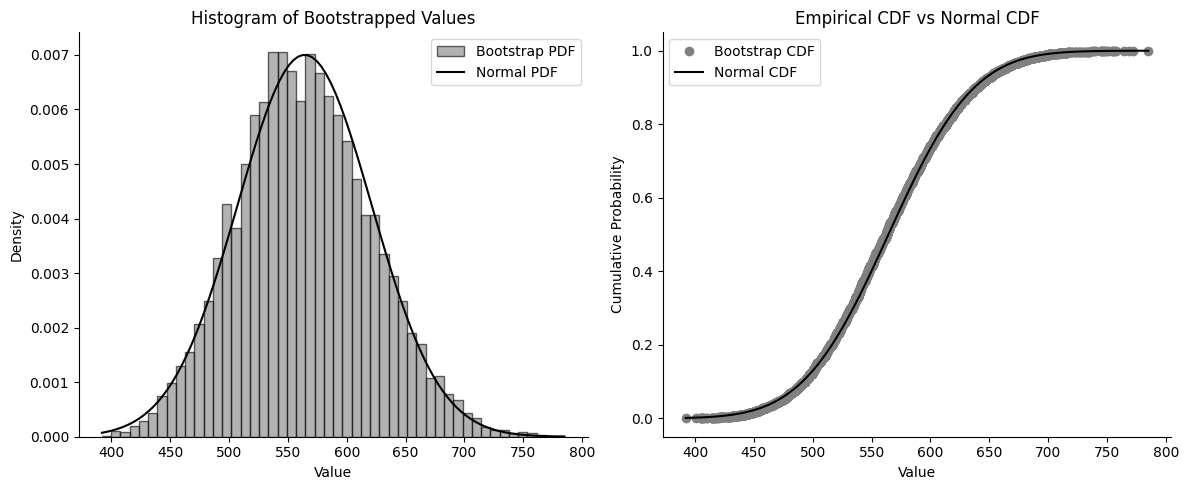

: 

: 

: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(results_simple, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(results_simple), max(results_simple), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(results_simple)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [ ]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

: 

: 

: 

In [ ]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

: 

: 

: 

In [ ]:
_, p_value = stats.normaltest(norm_samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

0.012248796881928087
Reject the null hypothesis: The data does not appear to be normally distributed.


: 

: 

: 

In [ ]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

Reject the null hypothesis: The data does not appear to be normally distributed.


/home/chnaeher/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


: 

: 

: 